In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.special import boxcox1p
from scipy import sparse
from category_encoders import BinaryEncoder
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion, _fit_transform_one, _transform_one
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,make_scorer
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline
sns.set_style("whitegrid",{'axes.grid':False})

## Data Science Work Flow:

1) Defining the question to be answered and understanding the kind of data we need.

2) Data Acquisition.

3) Data Cleaning and normalization.

4) Data Visualization.

5) Model Selection.

6) Adjusting model hyperparameters.

7) Setup performance metrics and evaluation.

8) Interpret Model and reports visually.

## Defining the question.

**Can we predict the price one can charge for a particular stay in the city of berlin?**

To be able to answer such a question we would need prehistoric data of stays in Berlin and the price they had been charged.

## Data Acquisition

**I used the dataset berlin airbnb available on Kaggle.com. From the 6 available datasets we used the listings dataset as this comprises of all the data we require in a clear and concise manner.**

**This data was scrapped off the airbnb website and compiled for analysis**

Lets have a look at our data set

In [3]:
df=pd.read_csv(r'C:\Users\MUKU\Desktop\Python\Data sets\Berlin_airbnb\listings.csv')

In [4]:
df.sample(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
15382,21216350,Ella,153286671,Frank,Pankow,Helmholtzplatz,52.542223,13.424357,Entire home/apt,67,2,17,2018-10-28,1.31,1,0
5594,8027975,Luxurious & artistic furnished room,42388679,Peter,Tempelhof - Schöneberg,Schöneberg-Süd,52.488762,13.349191,Private room,40,3,1,2016-05-18,0.03,1,36
9132,13743418,One room in very nice 2 room app in Kreuzberg ...,80469366,Mathias,Friedrichshain-Kreuzberg,nördliche Luisenstadt,52.502369,13.416336,Private room,50,4,0,NaN,NaN,1,0
18822,24865159,Cozy room in heart of Kreuzkölln (Hermann Platz),75961099,Julie,Friedrichshain-Kreuzberg,Tempelhofer Vorstadt,52.486825,13.422474,Private room,55,2,6,2018-10-28,1.05,3,143
9123,13737670,Cozy big Room in Berlin Neukoelln,80410216,Janne,Neukölln,Rixdorf,52.482879,13.443698,Private room,27,2,8,2016-09-03,0.28,1,0


### This is our dataset. we shall use the help of a few methods from the library Pandas to get an overview of our data.

**id** : This is a unique value assigned to every stay.

**name** : The name of every stay.

**host_id**: This is a unique id given to every host that puts up a listing on the website.

**host_name**: The name of the host.

**neighbourhood_group**: One of the levels of location of the stay.

**neighbourhood** : The neighbourhood the stay is located in.

**latitude**: The Latitude values of the stay.

**longitude** The Longitude values of the stay.

**room_type**: The type of stay that is provided in the listing.

**price**: The price that was charged per day.(The variable we want to predict)

**minimum_nights**: The minimum number of nights that one can book the stay for.

**number_of_reviews**: The total number of reviews that the stay has gotten up to date.

**last_review**: The date of the last review.

**reviews_per_month**: The average number of reviews the stay recieves per month.

**calculated_host_listings_count** : The total number of listings the host has put up of the stay.

**availability_365** : How many days of the year is the stay available.

### We use the .describe() method to get general statistics of our numerical variables.

In [5]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,2.255200e+04,2.255200e+04,22552.000000,22552.000000,22552.000000,22552.000000,22552.000000,18638.000000,22552.000000,22552.000000
mean,1.571560e+07,5.403355e+07,52.509824,13.406107,67.143668,7.157059,17.840679,1.135525,1.918233,79.852829
std,8.552069e+06,5.816290e+07,0.030825,0.057964,220.266210,40.665073,36.769624,1.507082,3.667257,119.368162
min,2.015000e+03,2.217000e+03,52.345803,13.103557,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,8.065954e+06,9.240002e+06,52.489065,13.375411,30.000000,2.000000,1.000000,0.180000,1.000000,0.000000
50%,1.686638e+07,3.126711e+07,52.509079,13.416779,45.000000,2.000000,5.000000,0.540000,1.000000,4.000000
75%,2.258393e+07,8.067518e+07,52.532669,13.439259,70.000000,4.000000,16.000000,1.500000,1.000000,129.000000
max,2.986735e+07,2.245081e+08,52.651670,13.757642,9000.000000,5000.000000,498.000000,36.670000,45.000000,365.000000


### Making a heatmap of all the null values for an overview look.

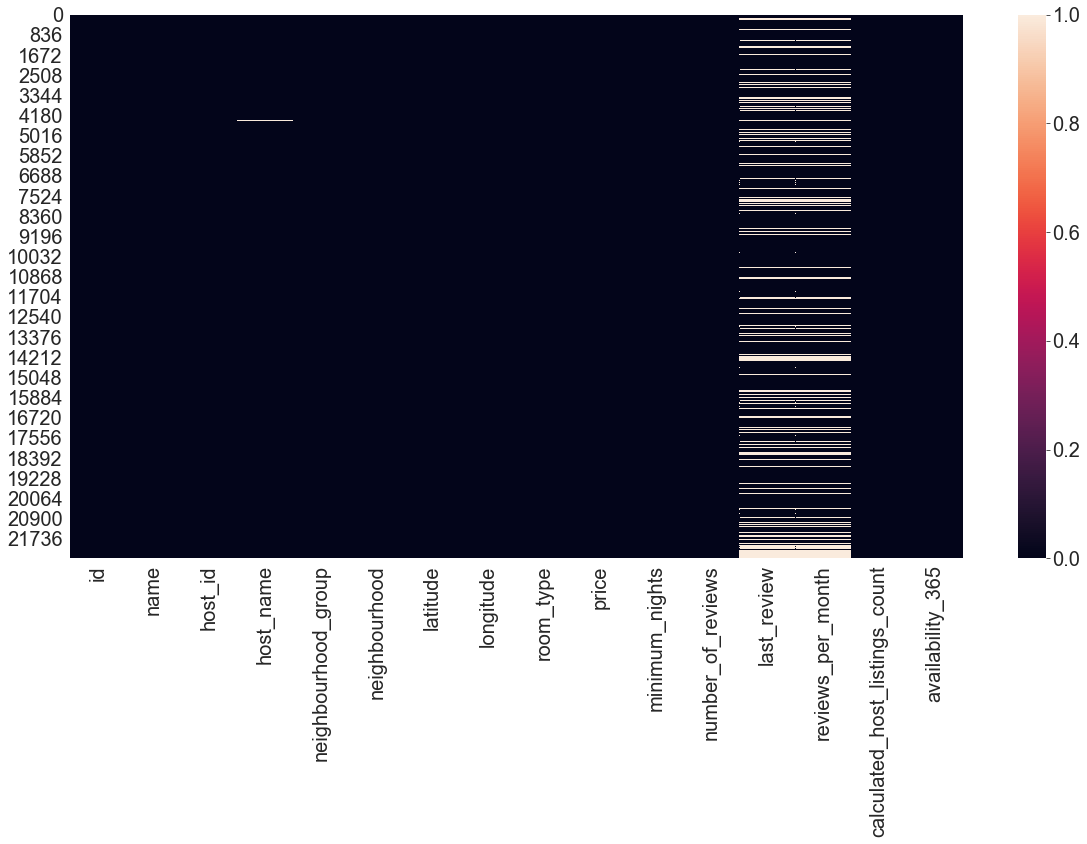

In [6]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':20})
null_map_cleaned=sns.heatmap(df.isnull())

# Inferences:

-  Here we can see that the columns **last_review**,**reviews_per_month**,**name** and **host_name** have the most number of missing values.



-  Also we notice that the variables **last_review** and **reviews_per_month** have missing values in the exact same places. It is most likely because the variable **reviews_per_month** is directly related to **last_review**.If there was no last review, then there wouldnt be any reviews per month.

# Data cleaning and normalization:

In [7]:
df[df.columns].nunique()

id                                22552
name                              21873
host_id                           19180
host_name                          5997
neighbourhood_group                  12
neighbourhood                       136
latitude                          22552
longitude                         22552
room_type                             3
price                               295
minimum_nights                      102
number_of_reviews                   306
last_review                        1312
reviews_per_month                   768
calculated_host_listings_count       23
availability_365                    366
dtype: int64

We will be making separate pipelines for different types of categorical variables and numerical variables.

Variables we shall be dropping:
-  id
-  name
-  host_id
-  host_name

We drop these variables as they provide no benefit for our models.

Categorical Variables for One-Hot-Encoding:
-  neighbourhood_group
-  room_type

We use one hot encoding on these variables as they have a cardinality of less than 15.

Categorical Variables for Binary Encoding:
-  neighbourhood

We use Binary coding on these variables as they have a cardinality of more than 15.

Numerical Variables for K-Means Clustering.
-  latitude
-  longitude                         

We will use K-Means clustering to first segerate the co-ordinates into clusters and then we use One-Hot-Encoding on the clusters.

Numerical Variables for Robust Scaling:
-  price(Target)                                                            
-  minimum_nights   
-  number_of_reviews    
-  last_review   
-  reviews_per_month
-  calculated_host_listings_count
-  availability_365



In [8]:
# Dropping the columns that cannot be used by machine learning algorithms.
df=df.drop(['id','name','host_id','host_name'],axis=1)

In [9]:
# Replacing the null values with 0.0001 for the reviews_per_month column
df['reviews_per_month'].replace(pd.np.nan,0.0001,inplace=True)

# Replacing the 0 with 0.001 in the price column
df['price'].replace(0,0.001,inplace=True)

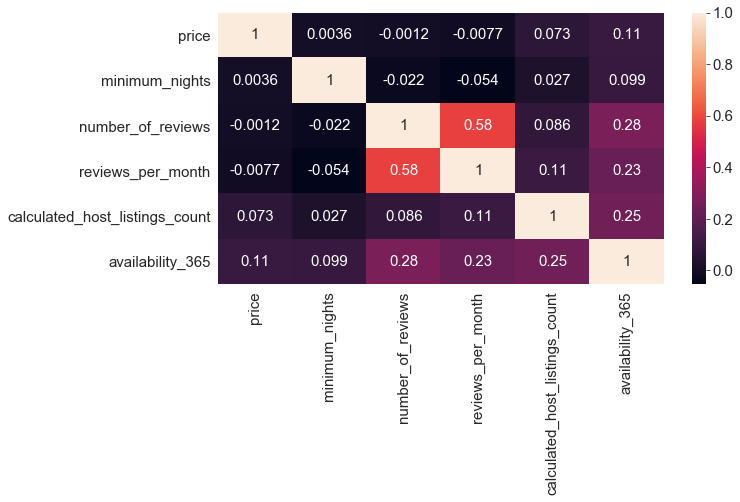

In [10]:
# Plotting a heat map for analysing the co-relations of the numerical variables.
plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size':15})
corr_plot=sns.heatmap(df.drop(['latitude','longitude'],axis=1).corr(),annot=True)

## Inferences:
-  We can see that the price isnt as highly correlated with most of the numerical values. The largest value is 0.11 which is with availability of the stay over a time period of a year.

-  The only other variables that seem to be quite correlated are **number_of_reviews** and **reviews_per_month**. This was quite obvious.

# Just a quick overview look of our coordinates.

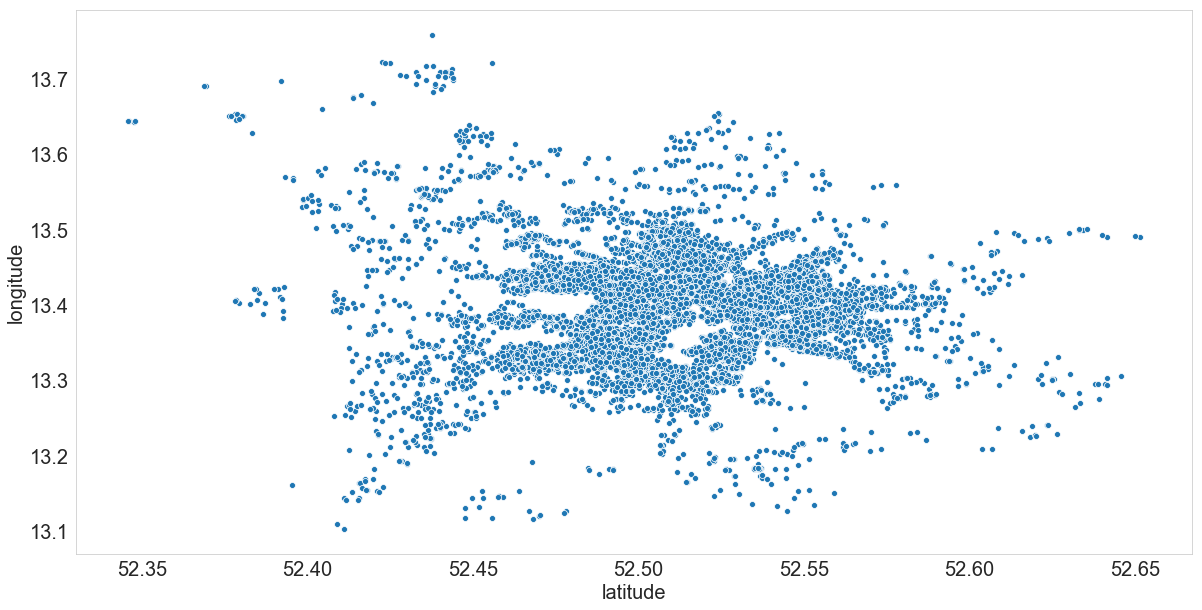

In [11]:
# Plotting all the co-ordinates
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':20})
lat_lng=sns.scatterplot(x='latitude',y='longitude',data=df)

Subselecting only the latitude and longitude variables.

In [12]:
# Hyperparameter optimization for K-Means Algorithm
df_lat_lng=df[['latitude','longitude']]
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i,n_jobs=3).fit(df_lat_lng) for i in Ks]

Setting up a range of values for the parameter k and initializing the the KMeans algorithm.

Writing a function to plot the elbow plot. This plot basically shows the percentage  of variance that is explained vs the number of clusters. The main objective is  to identify which value is the elbow in our curve. This is the most optimal value for our clustering.

In [13]:
# Function to plot elbow plot
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

<Figure size 1440x720 with 0 Axes>

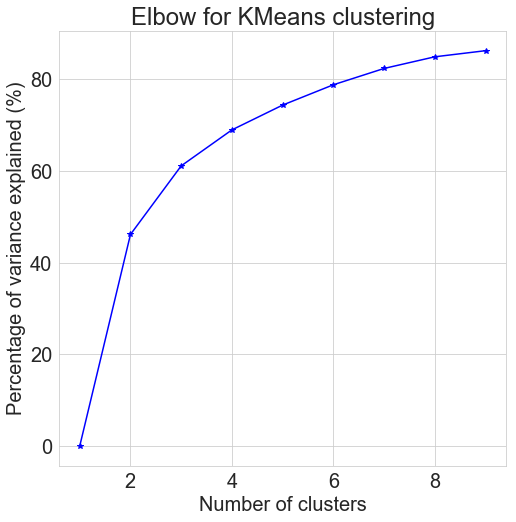

In [14]:
#plotting the elbow plot
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size':20})
plot_elbow(kmean, df_lat_lng)

### It seems like the elbow is formed  at the point where k=3. Hence we shall use k as 3 for our clustering problem.

In [15]:
# A simple class to used in ur pipelines for selecting features from a list.
class FeatureSelector(BaseEstimator,TransformerMixin):
    def __init__(self,feature_names):
        self._feature_names = feature_names
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X[self._feature_names]

In [16]:
# A simple class that uses a function to make transformations and returns them in pandas dataframes instead of matrices.
class PandasTransform(TransformerMixin, BaseEstimator):
    def __init__(self, fn):
        self.fn = fn

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, copy=None):
        return self.fn(X)

In [17]:
# A simple function to perform KMeans clustering
def kmc(df):
    km=KMeans(n_clusters=3,random_state=42)
    df['clusters']=km.fit_predict(df)
    map_dict={0:'cluster1',1:'cluster2',2:'cluster3'}
    def converter(X):
        return map_dict[X]
    return df['clusters'].apply(converter)

In [18]:
# A simple function to perform transformations on numerical variables.
def rs(df):
    mms=MinMaxScaler((0.01,1))
    rs_df=pd.DataFrame(mms.fit_transform(df))
    rs_df.columns=df.columns
    return rs_df

In [19]:
# A simple function to binary encode categorical values with high cardinality.
def be(df):
    be=BinaryEncoder(drop_invariant=True)
    return be.fit_transform(df[cat_be])

In [20]:
# A Class that is a wrap around the FeatureUnion class from sklearn. The only difference is it returns values in the pandas 
# dataframe format  instead of matrices.
class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [21]:
# A simple function that takes in the last_review column and splits it into its temporal components.
def date_transform(df):
    imp=SimpleImputer(strategy='most_frequent')
    dates=imp.fit_transform(np.array(df).reshape(-1,1))
    dates=pd.Series(dates.reshape(22552,))
    dates=pd.to_datetime(dates)
    date_df=pd.DataFrame()
    date_df['year']=dates.dt.year
    date_df['month']=dates.dt.month
    date_df['day']=dates.dt.day
    return date_df

Segregating our variables into lists to be put through the data flow pipeline.

In [22]:
# Categorical Variables that need to be one-hot-coded.
cat_ohc=['neighbourhood_group','room_type','calculated_host_listings_count']

# Categorical variables that need to be BinaryEncoded.
cat_be=['neighbourhood']

# latitudes and longitudes to be converted to clusters and then one-hot-coded.
num_kmc=['latitude','longitude']

# Numerical variables that will be transformed for the linear models.
num_rs=['minimum_nights','number_of_reviews','reviews_per_month','availability_365']

# The date values in the dataframe.
num_date=['last_review']

Pipelines are best practice when it comes to transforming different parts of data sets in a parallel manner and further rejoin them back using feature unions

In [23]:
# Categorical variable pipeline that needs one-hot-coding.
cat_ohc_pipe=Pipeline(memory=None,steps=[('feature_selector',FeatureSelector(cat_ohc)),('ohc',PandasTransform(lambda X: pd.get_dummies(X,drop_first=True)))])

# Categorical varialbe pipeline that needs Binary encoding.
cat_be_pipe=Pipeline(memory=None,steps=[('feature_selector',FeatureSelector(cat_be)),('be',PandasTransform(lambda X: be(X)))])

# Latitude and Longtitude pipeline for transforming co-ordinates to clusters and one-hot-coding the clusters.
num_kmc_pipe=Pipeline(memory=None,steps=[('feature_selector',FeatureSelector(num_kmc)),('kmc',PandasTransform(lambda X: kmc(X))),('ohc',PandasTransform(lambda X: pd.get_dummies(X,drop_first=True)))])

# Numerical values that need to be transformed for the linear models.
num_rs_pipe=Pipeline(memory=None,steps=[('feature_selector',FeatureSelector(num_rs)),('rs',PandasTransform(lambda X: rs(X)))])

# Date variables that are broken into their components of year,month and day.
num_date_pipe=Pipeline(memory=None,steps=[('feature_selector',FeatureSelector(num_date)),('date_transform',PandasTransform(lambda X: date_transform(X)))])

# Selection of the numerical variables as they are for the decision tree methods.
num_only_pipe=Pipeline(memory=None,steps=[('feature_selector',FeatureSelector(num_rs))])

Joining the pipelines and stictching the output using the custom class PandasFeatureUnion(This returns a dataframe instead of matrix).

We make two seperate feature unions 

In [24]:
#Decision tree pipeline(Without numerical transformations)
feat_uni_dtree=PandasFeatureUnion(transformer_list=[('cat_ohc_pipe',cat_ohc_pipe),
                                                    ('cat_be_pipe',cat_be_pipe),
                                                    ('num_kmc_pipe',num_kmc_pipe),
                                                    ('num_only_pipe',num_only_pipe),
                                                    ('num_date_pipe',num_date_pipe)])

# Linear models pipeline(With numerical transformations)                                            
feat_uni_lm=PandasFeatureUnion(transformer_list=[('cat_ohc_pipe',cat_ohc_pipe),
                                                 ('cat_be_pipe',cat_be_pipe),
                                                 ('num_kmc_pipe',num_kmc_pipe),
                                                 ('num_rs_pipe',num_rs_pipe),
                                                 ('num_date_pipe',num_date_pipe)])

# Model selection

## Decision Tree Models:
-  Decision Tree Regresion
-  Random Forest Regresion
-  Gradient Boosted Regresion

In [25]:
dtr=DecisionTreeRegressor(random_state=42)
rfr=RandomForestRegressor(random_state=42)
gbr=GradientBoostingRegressor(random_state=42)

#A list of all the decision tree models
tree_regressors=[dtr,rfr,gbr]

## Linear Models:
-  Lasso Regression
-  Ridge Regression
-  ElasticNet Regression
-  Support Vector Regression

In [26]:
lasso=Lasso(random_state=42)
ridge=Ridge(random_state=42)
enet=ElasticNet(random_state=42)
svr=SVR()

# A list of all the linear models
linear_regressors=[lasso,ridge,enet,svr]

In [27]:
# A simple function that takes in a featre union and a model and prints out the RMSE,MSE and R^2 scores.
def model_runner(model,feature_union):
    feature_union.fit(df)
    global X
    X=feature_union.transform(df)
    global y
    y=df['price'].apply(np.log1p)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    model.fit(X_train,y_train)
    y_test=np.exp(y_test)
    preds=model.predict(X_test)
    preds=np.exp(preds)
    print('{}'.format(str(model).split('(')[0]))
    print('RMSE:',np.sqrt(mean_squared_error(y_test,preds)))
    print('MAE:',mean_absolute_error(y_test,preds))
    print('R2',r2_score(y_test,preds))
    print('\n')

In [28]:
# Printing out all the scores for the decision tree models
for model in tree_regressors:
    model_runner(model,feat_uni_dtree)

DecisionTreeRegressor
RMSE: 180.62598798014636
MAE: 38.86726857997187
R2 -0.1861991674821324


RandomForestRegressor
RMSE: 88.42867603539383
MAE: 24.454492216026793
R2 0.7156957255747751


GradientBoostingRegressor
RMSE: 145.44916502468018
MAE: 24.9991858606743
R2 0.2308348323119641




In [29]:
# Printing out all the scores for the linear models
for model in linear_regressors:
    model_runner(model,feat_uni_lm)

Lasso
RMSE: 166.50735295646552
MAE: 32.47303168807848
R2 -0.00800799584373979


Ridge
RMSE: 164.51109272187753
MAE: 26.736801708195767
R2 0.016017175547044626


ElasticNet
RMSE: 166.50735295646552
MAE: 32.47303168807848
R2 -0.00800799584373979


SVR
RMSE: 161.74416275508065
MAE: 26.275636058157716
R2 0.048838252461351095




# Hyper Parameter Optimization

The Random Forest Regressor seemed to do the best in comparison to all other models. Hence Random Forest is the model of our choice.

In [30]:
# Grid searching a range  of possible values of parameters for Random Forest regressor.
# gscv_rfr=GridSearchCV(rfr,param_grid={'n_estimators':[500,1000,2000],'max_depth':[5,10,20,50,100],'max_features':[5,10,20,30]},cv=2,n_jobs=4,scoring='neg_mean_squared_error')
# gscv_rfr.fit(X_train,y_train)

In [31]:
# Printing out the best parameters from the range provided  to GridSearchCV
# gscv_rfr.best_params_

In [32]:
# Fitting our model with the best parameters to get better scores and predictions.
rfr=RandomForestRegressor(n_estimators=2000,max_depth=20,max_features=31,n_jobs=4,random_state=42)
model_runner(rfr,feat_uni_dtree)

RandomForestRegressor
RMSE: 87.73342029493907
MAE: 23.249500933532275
R2 0.7201487409722998




In [33]:
def custom_scorer(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [34]:
rmse=make_scorer(custom_scorer,greater_is_better=False)

In [ ]:
# Cross validating with 5 folds and displaying the R^2 scores.  We are looking for the best possible fit and not aiming for high accuracy.
cross_val_score(rfr,X,y,scoring=rmse,cv=5,n_jobs=1)